# Step 0 — Install / imports

In [2]:
!pip -q install torch torchvision pandas numpy pillow scikit-learn tqdm

import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Step 1 — Load Your Metadata CSVs

You should have (or create) two CSV files:

### A.csv  
**Columns example:**  
image_path, age, gender, race

### B.csv  
**Columns example:**  
image_path, emotion

## Create A.csv and B.csv

In [12]:
import os
import pandas as pd

#datasetA_dir = r"C:\Users\bensa\Desktop\ETUDES\Deep Learning\Project\UTK-Face\part1"

datasetA_dir = r"/Users/renubandaru/Code/GitHub/facial-profiler/data/source_data/UTK-Face/part1"

rows = []

for fname in os.listdir(datasetA_dir):
    if fname.endswith(".jpg") or fname.endswith(".png"):
        
        # Remove extension first
        name = os.path.splitext(fname)[0]
        parts = name.split("_")
        
        # UTKFace format: age_gender_race_date
        if len(parts) >= 3:
            try:
                age = int(parts[0])
                gender = int(parts[1])
                race = int(parts[2])

                rows.append({
                    "image_path": os.path.join(datasetA_dir, fname),
                    "age": age,
                    "gender": gender,
                    "race": race
                })
            except ValueError:
                # Skip incorrectly formatted files
                continue

dfA = pd.DataFrame(rows)
dfA.to_csv("A.csv", index=False)

print("A.csv created")
print(dfA.head())


A.csv created
                                          image_path  age  gender  race
0  /Users/renubandaru/Code/GitHub/facial-profiler...   16       1     3
1  /Users/renubandaru/Code/GitHub/facial-profiler...   40       1     0
2  /Users/renubandaru/Code/GitHub/facial-profiler...   71       1     0
3  /Users/renubandaru/Code/GitHub/facial-profiler...   80       1     0
4  /Users/renubandaru/Code/GitHub/facial-profiler...   21       0     4


##  Dataset B already has a CSV 
Just rename columns:

In [13]:
dfB = pd.read_csv(r"/Users/renubandaru/Code/GitHub/facial-profiler/data/source_data/raf/train_labels.csv")
dfB = dfB.rename(columns={"emotion_column_name":"emotion",
                          "image_column_name":"image_path"})
dfB.to_csv("B.csv", index=False)

## Important Checks Before Step 1

In [14]:
import pandas as pd

print("Dataset A shape:", pd.read_csv("A.csv").shape)
print("Dataset B shape:", pd.read_csv("B.csv").shape)

Dataset A shape: (10137, 4)
Dataset B shape: (12271, 2)


Also verify that images load correctly:

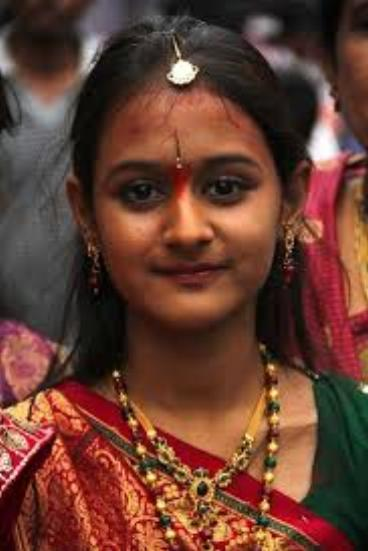

In [16]:
from PIL import Image

sample = pd.read_csv("A.csv").iloc[0]["image_path"] 
Image.open(sample)

## Load your metadata CSVs

In [17]:
dfA = pd.read_csv("A.csv")
dfB = pd.read_csv("B.csv")

print(dfA.head())
print(dfB.head())

                                          image_path  age  gender  race
0  /Users/renubandaru/Code/GitHub/facial-profiler...   16       1     3
1  /Users/renubandaru/Code/GitHub/facial-profiler...   40       1     0
2  /Users/renubandaru/Code/GitHub/facial-profiler...   71       1     0
3  /Users/renubandaru/Code/GitHub/facial-profiler...   80       1     0
4  /Users/renubandaru/Code/GitHub/facial-profiler...   21       0     4
                     image  label
0  train_00001_aligned.jpg      5
1  train_00002_aligned.jpg      5
2  train_00003_aligned.jpg      4
3  train_00004_aligned.jpg      4
4  train_00005_aligned.jpg      5


## Step 2 — Decide Label Formats (Especially for Age)

**Age:** Strongly recommended to use age bins (more stable than exact age).

### Example Age Bins:

0–9  
10–19  
20–29  
30–39  
40–49  
50–59  
60+

In [ ]:
# Define age bins and labels
age_bins = [0,10,20,30,40,50,60,200]
age_bin_labels = list(range(len(age_bins)-1))  # 0..6

# Function to convert age to age bin
def age_to_bin(age):
    return int(np.digitize(age, age_bins) - 1)

# Apply the function to create a new 'age_bin' column
dfA["age_bin"] = dfA["age"].apply(age_to_bin)

For gender and race, you need them as integer class IDs already. If they’re strings, map them:

In [ ]:
# Example if gender is strings like "male"/"female"
# In UTK-Face, gender is already numeric (0 or 1), so this step is just for demonstration
if dfA["gender"].dtype == "object":
    gender_map = {g:i for i,g in enumerate(sorted(dfA["gender"].unique()))}
    dfA["gender_id"] = dfA["gender"].map(gender_map)
else:
    dfA["gender_id"] = dfA["gender"]

# Example if race is strings
if dfA["race"].dtype == "object":
    race_map = {r:i for i,r in enumerate(sorted(dfA["race"].unique()))}
    dfA["race_id"] = dfA["race"].map(race_map)
else:
    dfA["race_id"] = dfA["race"]

num_age = dfA["age_bin"].nunique()
num_gender = dfA["gender_id"].nunique()
num_race = dfA["race_id"].nunique()

(num_age, num_gender, num_race)

(7, 3, 7)

# Step 3 — Build a Dataset + DataLoader

In [ ]:
# Define a PyTorch Dataset for the face data
# This will be used for both datasets, with a flag to indicate if demographic labels are present
class FaceDataset(Dataset):
    def __init__(self, df, transform=None, has_demo_labels=True):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.has_demo_labels = has_demo_labels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)

        if self.has_demo_labels:
            y_age = int(row["age_bin"])
            y_gender = int(row["gender_id"])
            y_race = int(row["race_id"])
            return img, (y_age, y_gender, y_race)
        else:
            return img, row["image_path"]

Transforms:

In [22]:
# Define transformations for the images 
# These are standard transformations for training a CNN on image data.
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

Split A into train/val:

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Correct stratify column
# We need to ensure that we have at least 2 samples per class in the stratify column to avoid errors during splitting.
counts = dfA['gender'].value_counts()
dfA_filtered = dfA[dfA['gender'].isin(counts[counts >= 2].index)]

# Now we can safely split the data
trainA, valA = train_test_split(
    dfA_filtered,
    test_size=0.2,
    random_state=42,
    stratify=dfA_filtered['gender']
)

# Create Datasets and DataLoaders
ds_trainA = FaceDataset(trainA, transform=transform, has_demo_labels=True)
ds_valA   = FaceDataset(valA, transform=transform, has_demo_labels=True)

dl_trainA = DataLoader(ds_trainA, batch_size=32, shuffle=True, num_workers=2)
dl_valA   = DataLoader(ds_valA, batch_size=32, shuffle=False, num_workers=2)

# Step 4 — Define a multi-head demographics model (Age/Gender/Race)
Use a pretrained backbone (ResNet18) + 3 classifier heads.

In [24]:
# Define a simple multi-head CNN model using a pretrained ResNet backbone
# The model will have three heads for age, gender, and race classification.
class DemoNet(nn.Module):
    def __init__(self, num_age, num_gender, num_race):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.head_age = nn.Linear(in_features, num_age)
        self.head_gender = nn.Linear(in_features, num_gender)
        self.head_race = nn.Linear(in_features, num_race)

    def forward(self, x):
        feat = self.backbone(x)
        return {
            "age": self.head_age(feat),
            "gender": self.head_gender(feat),
            "race": self.head_race(feat)
        }

device = "cuda" if torch.cuda.is_available() else "cpu"
model = DemoNet(num_age, num_gender, num_race).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/renubandaru/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 40.0MB/s]


Losses + optimizer:

In [25]:
# Define loss functions and optimizer
# We will use CrossEntropyLoss for all three heads since they are classification tasks.
# Note: In a real implementation, you might want to weight the losses differently or use a more sophisticated multi-task loss.
ce = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

# Step 5 — Train the demographics model on Dataset A

In [ ]:
# Training loop with evaluation
# We will train for a few epochs and evaluate on the validation set after each epoch.
@torch.no_grad()
def evaluate(model, dl):
    model.eval()
    correct = {"age":0, "gender":0, "race":0}
    total = 0
    for x, (y_age, y_gender, y_race) in dl:
        x = x.to(device)
        y_age = y_age.to(device)
        y_gender = y_gender.to(device)
        y_race = y_race.to(device)

        out = model(x)
        pred_age = out["age"].argmax(1)
        pred_gender = out["gender"].argmax(1)
        pred_race = out["race"].argmax(1)

        total += x.size(0)
        correct["age"] += (pred_age == y_age).sum().item()
        correct["gender"] += (pred_gender == y_gender).sum().item()
        correct["race"] += (pred_race == y_race).sum().item()

    return {k: correct[k]/total for k in correct}

# We will train for a few epochs and evaluate on the validation set after each epoch
def train_one_epoch(model, dl):
    model.train()
    running = 0.0
    for x, (y_age, y_gender, y_race) in dl:
        x = x.to(device)
        y_age = y_age.to(device)
        y_gender = y_gender.to(device)
        y_race = y_race.to(device)

        out = model(x)
        loss = ce(out["age"], y_age) + ce(out["gender"], y_gender) + ce(out["race"], y_race)

        opt.zero_grad()
        loss.backward()
        opt.step()
        running += loss.item() * x.size(0)

    return running / len(dl.dataset)

for epoch in range(5):
    tr_loss = train_one_epoch(model, dl_trainA)
    metrics = evaluate(model, dl_valA)
    print(f"Epoch {epoch+1}: loss={tr_loss:.4f} val_acc={metrics}")

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'FaceDataset' on <module '__main__' (built-in)>


# Step 6 — Infer pseudo-labels for Dataset B (emotion-only)

In [ ]:
ds_B = FaceDataset(dfB, transform=transform, has_demo_labels=False)
dl_B = DataLoader(ds_B, batch_size=64, shuffle=False, num_workers=2)

softmax = nn.Softmax(dim=1)

@torch.no_grad()
def pseudo_label_B(model, dl):
    model.eval()
    rows = []
    for x, paths in tqdm(dl):
        x = x.to(device)
        out = model(x)

        p_age = softmax(out["age"])
        p_gender = softmax(out["gender"])
        p_race = softmax(out["race"])

        age_pred = p_age.argmax(1).cpu().numpy()
        gender_pred = p_gender.argmax(1).cpu().numpy()
        race_pred = p_race.argmax(1).cpu().numpy()

        age_conf = p_age.max(1).values.cpu().numpy()
        gender_conf = p_gender.max(1).values.cpu().numpy()
        race_conf = p_race.max(1).values.cpu().numpy()

        for path, a,g,r,ca,cg,cr in zip(paths, age_pred, gender_pred, race_pred, age_conf, gender_conf, race_conf):
            rows.append({
                "image_path": path,
                "age_pseudo": int(a),
                "gender_pseudo": int(g),
                "race_pseudo": int(r),
                "age_conf": float(ca),
                "gender_conf": float(cg),
                "race_conf": float(cr),
            })
    return pd.DataFrame(rows)

dfB_pseudo = pseudo_label_B(model, dl_B)
dfB_aug = dfB.merge(dfB_pseudo, on=r"C/Users/renubandaru/Code/GitHub/facial-profiler/data/B.csv", how="left")
dfB_aug.head()

# Step 7 — Confidence filtering (important!)
You don’t want to treat low-confidence guesses as truth.

Example: if confidence < 0.80, mark as unknown (-1).

In [ ]:
TH = 0.80

for col, conf in [("age_pseudo","age_conf"), ("gender_pseudo","gender_conf"), ("race_pseudo","race_conf")]:
    dfB_aug.loc[dfB_aug[conf] < TH, col] = -1

In [ ]:
dfB_aug.to_csv(r"C:\Users\bensa\Desktop\ETUDES\Deep Learning\Project\B_with_pseudo_demographics.csv", index=False)

# Step 8 — Merge A + B into one unified dataset file
Keep true labels separate from pseudo labels so you don’t confuse them.

In [ ]:
dfA_out = dfA.copy()
dfA_out["emotion"] = np.nan
dfA_out["source"] = "A_true_demo"
dfA_out["age_true"] = dfA_out["age_bin"]
dfA_out["gender_true"] = dfA_out["gender_id"]
dfA_out["race_true"] = dfA_out["race_id"]

dfA_out["age_pseudo"] = np.nan
dfA_out["gender_pseudo"] = np.nan
dfA_out["race_pseudo"] = np.nan
dfA_out["age_conf"] = np.nan
dfA_out["gender_conf"] = np.nan
dfA_out["race_conf"] = np.nan

dfB_out = dfB_aug.copy()
dfB_out["source"] = "B_true_emotion"
dfB_out["age_true"] = np.nan
dfB_out["gender_true"] = np.nan
dfB_out["race_true"] = np.nan

# Make sure columns exist / align
keep_cols = ["image_path","emotion","source",
             "age_true","gender_true","race_true",
             "age_pseudo","gender_pseudo","race_pseudo",
             "age_conf","gender_conf","race_conf"]

merged = pd.concat([dfA_out[keep_cols], dfB_out[keep_cols]], ignore_index=True)
merged.to_csv(r"C:\Users\bensa\Desktop\ETUDES\Deep Learning\Project\merged_A_B.csv", index=False)
print("File save attempted")
merged.head()

# Step 9 — How you train after merging (key idea)

When training a multi-task model later:

If age_true exists → train age head with it

Else if age_pseudo != -1 → optionally train with pseudo-label

Else → skip age loss for that sample

Same for gender/race.

This is the right way to use the merged file without corrupting training.